In [1]:
#Package needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz
from numpy import fft

In [2]:
#Simple function to convert unsigned number in signed
def convert_tosigned(x, nbits):
    if x >= 2**(nbits-1):
        x -= 2**nbits
    return x

0.1
FIR filter coefficients:  [0.03383324 0.24012702 0.45207947 0.24012702 0.03383324]


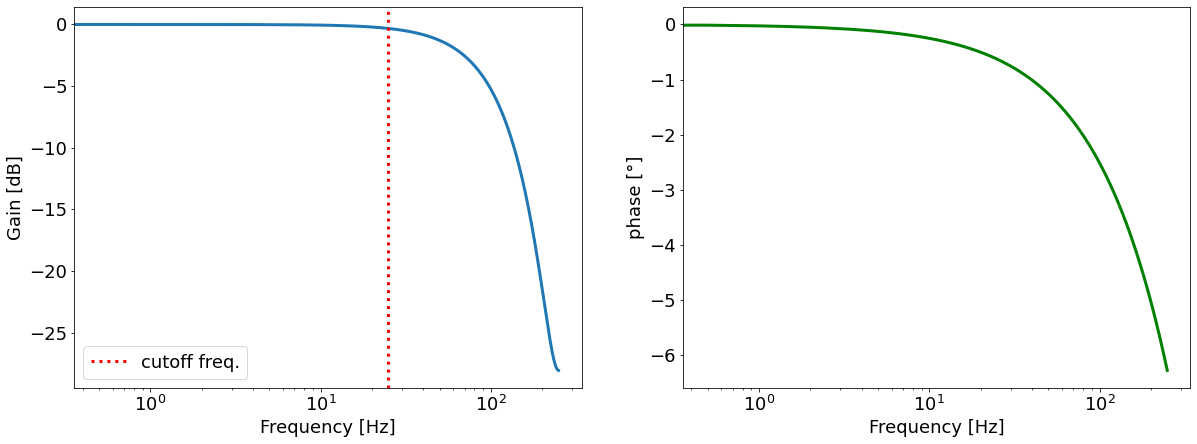

In [3]:
taps = 5
fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))
print("FIR filter coefficients: ", coeff)

f, h = freqz(coeff, fs = 500)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 3)
angles = np.unwrap(np.angle(h))
ax2.plot(f, angles, color = 'green', lw = 3)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
#ax1.set_title('Frequency Response')
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax2.set_xlabel('Frequency [Hz]', fontsize = 18)
ax2.set_ylabel('phase [°]', fontsize = 18)
#ax2.set_title('Phase Response')
ax2.set_xscale('log')

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

plt.savefig('Bode.png', dpi = 300)
plt.show()

0.1


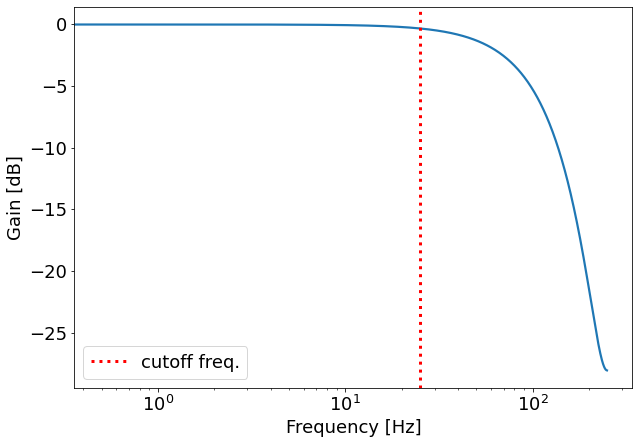

In [4]:

fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))

f, h = freqz(coeff, fs = 500)
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 2.2)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax1.tick_params(labelsize=18)

plt.savefig('Bode_150.png', dpi = 300)
plt.show()

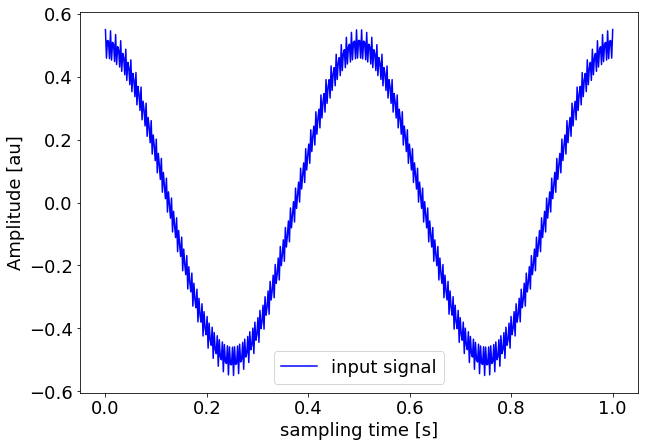

In [5]:
#Defining a noisy input signal
freq = 2
nf = 500
sampling = np.linspace(0, 1, nf)
freq_noise = 200
sig_no_noise = 0.5*np.cos(2*np.pi*freq*sampling)
noise = 0.05 * np.cos(2*np.pi*freq_noise*sampling)
sig = sig_no_noise + noise
plt.figure(figsize = (10, 7))
plt.plot(sampling, sig, label='input signal', c='blue')
plt.xlabel('sampling time [s]', fontsize = 18)
plt.legend(fontsize = 18)
plt.ylabel('Amplitude [au]', fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('Input_signal.png', dpi = 300)
plt.show()

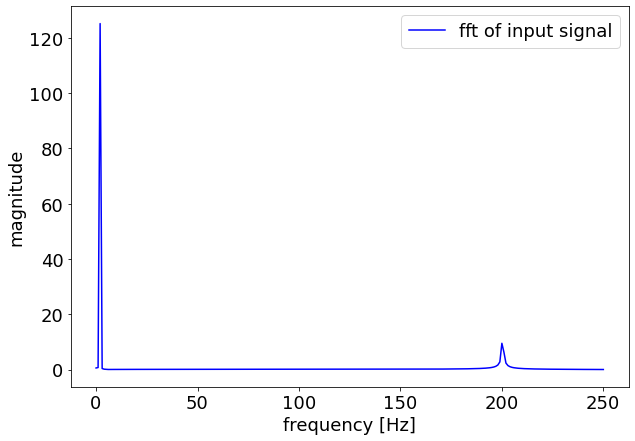

In [6]:
spectrum_sampl = fft.rfft(sig, nf)
freq_fourier = fft.rfftfreq(nf, d=1/nf)
plt.figure(figsize = (10, 7))
plt.xlabel('frequency [Hz]', fontsize = 18)
plt.ylabel('magnitude', fontsize = 18)
plt.plot(freq_fourier, np.abs(spectrum_sampl), label='fft of input signal', c='blue')
plt.legend(fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('Input_signal_fft.png', dpi = 300)
plt.show()

In [7]:
#Write 'sig' to file with conversion to signed integer for the FPGA
ofile = open('input_signal.txt', 'w')
sig_uns = np.zeros_like(sig)
sig_bin = np.zeros_like(sig)
for i in range(sig.size):
    sig_bin[i] = int(sig[i]*2**7)
    sig_uns[i] = int(np.binary_repr(int(sig[i]*2**7), width = 8), 2)
    ofile.write(str(int(sig_uns[i])) + '\n')
ofile.close()

## IDEAL BEAHAVIOUR

In [25]:
index = int((taps-1)/2)
filt_sig = np.zeros_like(sig)
for i in range(sig.size-taps+1):
    filt_sig[i+index] = np.dot(sig[i:taps+i], coeff[::-1])


array([ 0.        ,  0.        ,  0.5005801 ,  0.4996878 ,  0.494012  ,
        0.50010644,  0.49072752,  0.49356658,  0.49090229,  0.4838263 ,
        0.48829261,  0.47730747,  0.47875981,  0.47436114,  0.4659301 ,
        0.46881078,  0.45627639,  0.45639573,  0.4503247 ,  0.44060776,
        0.44196932,  0.42796643,  0.42682993,  0.41917203,  0.40826129,
        0.40819309,  0.39282504,  0.39053202,  0.3813948 ,  0.36940392,
        0.36801671,  0.35140784,  0.34807818,  0.3375896 ,  0.32465203,
        0.32207611,  0.30436988,  0.30014205,  0.28844846,  0.27471534,
        0.27109844,  0.25245524,  0.24748405,  0.23474787,  0.22038569,
        0.21589057,  0.19648526,  0.19093937,  0.17733654,  0.16252453,
        0.15732631,  0.13734551,  0.13140468,  0.1171219 ,  0.10204923,
        0.09633257,  0.0759718 ,  0.069824  ,  0.05505577,  0.03991858,
        0.0338747 ,  0.01333534,  0.00717372, -0.00788069, -0.02288238,
       -0.02905882, -0.04957262, -0.05555287, -0.07069258, -0.08

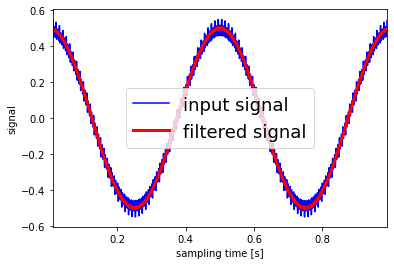

In [9]:
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, filt_sig, c='r', label='filtered signal', lw = 3)
plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(fontsize = 18)

plt.show()

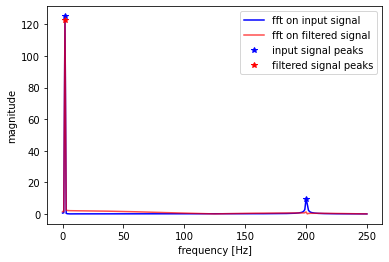

In [10]:
spectrum_filtered = fft.rfft(filt_sig, nf)
freq_filtered = fft.rfftfreq(nf, d=1/nf)



magnitude = np.abs(spectrum_sampl)
peaks, _ = scipy.signal.find_peaks(magnitude, height=5)

magnitude_filt = np.abs(spectrum_filtered)
peaks_filt, _ = scipy.signal.find_peaks(magnitude_filt, height=5)


plt.plot(freq_fourier, np.abs(spectrum_sampl), c='blue', label='fft on input signal')
plt.plot(freq_filtered, np.abs(spectrum_filtered), c='red', label='fft on filtered signal', alpha=0.7)
plt.plot(freq_fourier[peaks], magnitude[peaks], '*', label='input signal peaks', c='blue')
plt.plot(freq_filtered[peaks_filt], magnitude_filt[peaks_filt], '*', label='filtered signal peaks', c='r')
plt.legend(loc='best')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
plt.show()

In [11]:
print('input signal frequency analysis')
for i in peaks:
    str0 = f'frequency at which the input signal dispays peaks: {freq_fourier[i]} magnitude {magnitude[i]}'
    print(str0)

print('filtered signal frequency analysis')
for i in peaks_filt:
    str0 = f'frequency at which the filtered signal dispays peaks: {freq_filtered[i]} magnitude {magnitude_filt[i]}'
    print(str0)

input signal frequency analysis
frequency at which the input signal dispays peaks: 2.0 magnitude 125.17183675828915
frequency at which the input signal dispays peaks: 200.0 magnitude 9.48971658018734
filtered signal frequency analysis
frequency at which the filtered signal dispays peaks: 2.0 magnitude 123.09623140078173


In [12]:
ofile = open('ideal_output_signal.txt', 'w')
filt_sig_bin = np.zeros_like(filt_sig)
for i in range(filt_sig.size):
    filt_sig_bin[i] = int(filt_sig[i]*2**7)
    ofile.write(str(filt_sig_bin[i]) + '\n')
ofile.close()

## SIMULATION

In [13]:
coeff_int = np.zeros_like(coeff)
coeff_bin = []

for i in range(taps):
    coeff_int[i] = (round(coeff[i]*2**7, 0))

for i in range(taps):
    coeff_bin.append(bin(int(coeff_int[i])))

print(coeff_int, '\n', coeff_bin)


[ 4. 31. 58. 31.  4.] 
 ['0b100', '0b11111', '0b111010', '0b11111', '0b100']


In [24]:
y = np.zeros_like(sig)
sim_filt_sig = np.zeros_like(sig_uns)
for i in range(sig_bin.size-taps+1):
    y[i+index] = np.dot(sig_bin[i:taps+i], coeff_int[::-1]) 
    bin_19 = np.binary_repr(int(y[i+index]), 19)
    bin_8 = bin_19[4:12]
    int_8 = int(bin_8, 2)
    sim_filt_sig[i+index] = convert_tosigned(int_8, 8)


array([  0.,   0.,  63.,  63.,  62.,  63.,  62.,  62.,  62.,  61.,  62.,
        60.,  60.,  60.,  59.,  59.,  57.,  57.,  57.,  56.,  56.,  54.,
        54.,  53.,  51.,  51.,  50.,  49.,  48.,  46.,  46.,  44.,  44.,
        42.,  41.,  40.,  38.,  37.,  36.,  34.,  34.,  31.,  30.,  29.,
        27.,  27.,  24.,  23.,  22.,  20.,  19.,  17.,  16.,  14.,  12.,
        11.,   9.,   8.,   6.,   4.,   3.,   1.,   0.,  -1.,  -3.,  -4.,
        -6.,  -7.,  -9., -11., -12., -14., -15., -17., -19., -20., -22.,
       -23., -25., -26., -27., -30., -30., -32., -33., -34., -36., -37.,
       -38., -40., -41., -43., -43., -44., -46., -47., -49., -49., -50.,
       -51., -52., -54., -54., -55., -56., -56., -57., -57., -58., -59.,
       -59., -61., -60., -61., -61., -61., -63., -62., -63., -63., -63.,
       -64., -63., -64., -64., -63., -64., -63., -64., -64., -63., -64.,
       -62., -62., -62., -61., -62., -60., -60., -60., -59., -59., -58.,
       -57., -57., -56., -56., -54., -54., -52., -5

In [15]:
df = pd.DataFrame()
df['Bin input uns'] = sig_uns
df['Bin input'] = sig_bin
df['Bin output'] = filt_sig_bin
df['Bin sim. output'] = sim_filt_sig

In [16]:
df.to_csv('Results.csv')

## Data fro FPGA

(498,)
(2,)


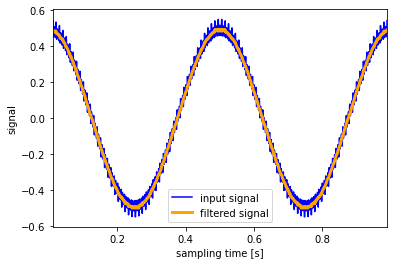

In [17]:
fpga = np.loadtxt('output_signal.txt')/2**7
print(fpga[2:].shape)
print(np.zeros(2).shape)
new = np.concatenate([fpga[2:], np.zeros(2)])
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, new, c='orange', label='filtered signal', lw = 3)
plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(loc='best')
plt.show()

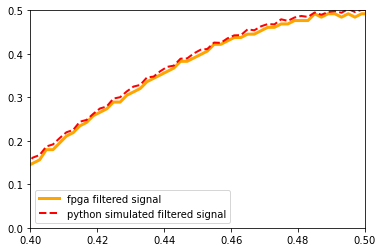

In [18]:
plt.plot(sampling, new, c='orange', label='fpga filtered signal', lw = 3)
plt.plot(sampling, filt_sig, c='r', label='python simulated filtered signal', lw = 2, ls = '--')
plt.xlim(0.4, 0.5)
plt.ylim(0.0, 0.5)
plt.legend()
plt.show()

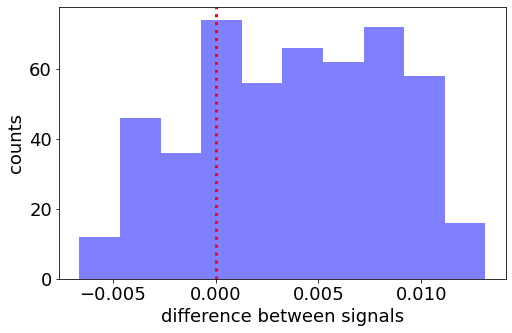

94.0 404.0


In [73]:
difference_true_fpga = filt_sig[2:] - new[2:]
difference_sim_fpga = sim_filt_sig/2**7 - new 

fig, ax = plt.subplots(1,1, figsize=(8, 5))
counts, bins, _ =  plt.hist(difference_true_fpga, bins=10, color='blue', alpha=0.5)
#ax.set_title('difference between python ideal filtered signal and fpga filtered signal', fontsize = 18)
ax.axvline(x=0, color = 'red', ls = 'dotted', lw = 3)
ax.set_xlabel('difference between signals', fontsize = 18)
#plt.legend(fontsize = 18)
ax.set_ylabel('counts', fontsize = 18)
ax.tick_params(labelsize=18)
plt.savefig('difference_histogram.png', dpi = 300)

plt.show()


bins
under_0 = counts[:3].sum()
over_0 = counts[3:].sum()
print(under_0, over_0)